# **Part 2 | Multi-Factor Analysis**
*An Analysis of Fama and French 5 Faktor Model with Momentum (and ESG Factor) on several ETFs on a 10-year time horizon*

In [25]:
#General Imports
import pandas as pd
import numpy as np
import os
import warnings

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

#Data Import
import yfinance as yf
import mplfinance as mpf

#Working with Data
from functools import reduce #Get Monthly Data
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#Estimation
import statsmodels.api as sm #Regression
from scipy import stats #Correlation
from scipy.stats import kendalltau, spearmanr #Kendal Tau

#Other Stuff
from IPython.display import display, Markdown  # For Markdown rendering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

The portfolios selected for factor analysis encompass a diverse range of investment strategies and market segments:

ESG-Focused Portfolios

1. Best ESG score portfolio
2. Worst ESG score portfolio

Global Market Portfolios

3. VT: Vanguard Total World Stock ETF
4. VEU: Vanguard FTSE All-World ex-US ETF

U.S. Market Segmented Portfolios

5. IVV: iShares Core S&P 500 ETF
6. IJH: iShares Core S&P Mid-Cap ETF
7. IJR: iShares Core S&P Small-Cap ETF

## **1. Data Collection**

### **1.1 Import ESG Data**

In [26]:
esg_data = pd.read_csv('__data/return_history.csv', delimiter = ",") #Importing ESG Factor Data

In [27]:
esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted['Date'] = esg_data_subsetted["Date"].dt.date

In [28]:
esg_data.tail()

,Date,Average_Return_High,Count_High,Average_Return_Low,Count_Low,ESG_Factor
263,2023-12-31,0.083022,373,0.115144,373,0.032122
264,2024-01-31,-0.018097,373,-0.037933,373,-0.019836
265,2024-02-29,0.031722,373,0.045612,373,0.013890
266,2024-03-31,0.046259,373,0.027716,373,-0.018543
267,2024-04-30,-0.047620,373,-0.065576,373,-0.017956


### **1.2 Importing Global Market & U.S. Market Return Data**

**Global Market Portfolios**

In [29]:
def preprocess(asset_name, start_date="2009-11-01", end_date="2024-11-01"):
    # Create 'data' folder if it doesn't exist
    data_folder = '__data'
    os.makedirs(data_folder, exist_ok=True)

    # Define the CSV filename
    csv_filename = os.path.join(data_folder, f'{asset_name.lower()}_data.csv')

    # Check if the CSV file already exists
    if not os.path.exists(csv_filename):
        # Download the data
        asset_data = yf.download(asset_name, start=start_date, end=end_date)
        # Reset the index to make the date a column
        asset_reset = asset_data.reset_index()
        # Rename the 'Date' column (which is now the first column)
        asset_reset = asset_reset.rename(columns={'Date': 'Date'})
        # Save to CSV file, skipping the first row (header) and without including the index
        asset_reset.to_csv(csv_filename, index = False, header = False)

    # Read the CSV file
    df = pd.read_csv(csv_filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

    df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime and set it as the index
    df.set_index('Date', inplace = True) #Set Date as Index
    df = df.sort_index() # Sort the index in ascending order

    df_monthly = df['Adj Close'].resample('M').last() #Get monthly Data

    df_monthly = df_monthly.reset_index()[["Date", "Adj Close"]]
    df_monthly['Date'] = df_monthly["Date"].dt.date #Remove time zone information from Date (Not needed)

    # Calculate returns and add a 'Return' column
    df_monthly["Return"] = df_monthly["Adj Close"].pct_change()

    # Remove the first row (which will have NaN for return)
    df_monthly = df_monthly.iloc[1:]

    # Keep only 'Date' and 'Return' columns as those are the only ones needed
    df_monthly = df_monthly[['Date', 'Return']]

    return df_monthly

In [30]:
# Process each dataset
vt = preprocess("VT")
veu = preprocess("VEU")

In [31]:
vt.head(10)

,Date,Return
1,2014-12-31,-0.019819
2,2015-01-31,-0.016300
3,2015-02-28,0.059520
4,2015-03-31,-0.012138
5,2015-04-30,0.025491
6,2015-05-31,0.003325
7,2015-06-30,-0.022203
8,2015-07-31,0.005039
9,2015-08-31,-0.066311
10,2015-09-30,-0.037109


**U.S. Market Portfolios**

In [32]:
# Process each dataset
ivv = preprocess("IVV")
ijh = preprocess("IJH")
ijr = preprocess("IJR")

**Renaming Columns**

In [33]:
vt = vt.rename(columns={"Return": "return_vt"})
veu = veu.rename(columns={"Return": "return_veu"})
ivv = ivv.rename(columns={"Return": "return_ivv"})
ijh = ijh.rename(columns={"Return": "return_ijh"})
ijr = ijr.rename(columns={"Return": "return_ijr"})

In [34]:
vt.head()

,Date,return_vt
1,2014-12-31,-0.019819
2,2015-01-31,-0.016300
3,2015-02-28,0.059520
4,2015-03-31,-0.012138
5,2015-04-30,0.025491


### **1.3 Importing Momentum Factor Data**

In [35]:
def prepMomentumData(data, suffix):

  data_adj = data.copy()

  data_adj["date"] = pd.to_datetime(data_adj["date"], errors='coerce')
  data_adj["date"] = data_adj["date"].dt.date

  data_adj = data_adj.rename(columns={'date': 'Date'})
  data_adj = data_adj.rename(columns={'ret': f"Mom_{suffix}_Factor"})

  data_adj = data_adj[["Date", f"Mom_{suffix}_Factor"]]

  return data_adj

In [36]:
mom_12_1 = pd.read_csv('__data/[usa]_[resff3_12_1]_[monthly]_[ew].csv', delimiter = ",") #Importing ESG Factor Data
mom_6_1 = pd.read_csv('__data/[usa]_[resff3_6_1]_[monthly]_[ew].csv', delimiter = ",") #Importing ESG Factor Data

In [37]:
mom_6_1 = prepMomentumData(mom_6_1, "6_1")
mom_12_1 = prepMomentumData(mom_12_1, "12_1")

In [38]:
mom_6_1.tail()

,Date,Mom_6_1_Factor
843,2023-08-31,0.016517
844,2023-09-30,0.000538
845,2023-10-31,-0.014745
846,2023-11-30,0.027283
847,2023-12-31,-0.016531


### **1.4. Importing Fama and French Data**

In [39]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2, index_col=0)


In [40]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2014-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2014-10-31,0.0252,0.0373,-0.0180,-0.0056,-0.0010,0.0
1,2014-11-30,0.0255,-0.0228,-0.0310,0.0150,0.0026,0.0
2,2014-12-31,-0.0006,0.0286,0.0227,-0.0122,0.0096,0.0
3,2015-01-31,-0.0311,-0.0092,-0.0359,0.0161,-0.0165,0.0
4,2015-02-28,0.0613,0.0032,-0.0186,-0.0112,-0.0182,0.0


### **1.5 Merging Data**

In [41]:
# Merge all datasets on the Date column
dataframes = [vt, veu, ivv, ijh, ijr, esg_data_subsetted, mom_12_1, mom_6_1, ff5]

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.head(10)

,Date,return_vt,return_veu,return_ivv,return_ijh,return_ijr,return_high_esg,return_low_esg,ESG_Factor,Mom_12_1_Factor,Mom_6_1_Factor,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2014-12-31,-0.019819,-0.039522,-0.002970,0.008344,0.028915,0.002209,-0.004320,-0.006529,-0.006055,0.021093,-0.0006,0.0286,0.0227,-0.0122,0.0096,0.0
1,2015-01-31,-0.016300,-0.000213,-0.029004,-0.011257,-0.035858,-0.022392,-0.021974,0.000419,0.018268,0.006628,-0.0311,-0.0092,-0.0359,0.0161,-0.0165,0.0
2,2015-02-28,0.059520,0.058485,0.056454,0.050848,0.060107,0.046598,0.066291,0.019693,-0.029002,-0.034502,0.0613,0.0032,-0.0186,-0.0112,-0.0182,0.0
3,2015-03-31,-0.012138,-0.014138,-0.015971,0.013354,0.016001,-0.013119,0.000508,0.013627,0.020135,0.034485,-0.0112,0.0307,-0.0038,0.0009,-0.0052,0.0
4,2015-04-30,0.025491,0.047404,0.009720,-0.014213,-0.023045,0.001217,0.004866,0.003650,-0.046951,-0.059439,0.0059,-0.0309,0.0182,0.0006,-0.0061,0.0
5,2015-05-31,0.003325,-0.010384,0.013009,0.016687,0.014570,0.008460,0.021605,0.013145,0.022637,0.017589,0.0136,0.0084,-0.0115,-0.0180,-0.0075,0.0
6,2015-06-30,-0.022203,-0.028093,-0.019817,-0.012348,0.010573,-0.025465,-0.008085,0.017379,0.008750,-0.007090,-0.0153,0.0290,-0.0079,0.0044,-0.0158,0.0
7,2015-07-31,0.005039,-0.002884,0.021909,0.000200,-0.008313,0.004966,0.001460,-0.003506,0.034223,-0.013400,0.0154,-0.0455,-0.0413,0.0030,-0.0242,0.0
8,2015-08-31,-0.066311,-0.077464,-0.061438,-0.055996,-0.051925,-0.053230,-0.044431,0.008799,-0.001446,-0.002896,-0.0604,0.0025,0.0277,0.0068,0.0119,0.0
9,2015-09-30,-0.037109,-0.040316,-0.024981,-0.031629,-0.035272,-0.029791,-0.051614,-0.021822,0.041038,0.030557,-0.0307,-0.0279,0.0056,0.0177,-0.0058,0.0


In [42]:
#Len data
len(data)

109

## **2 Visualizing Data**

### **2.1 Return Distributions**

In [43]:
def plotXReturnDistributions(data_list, column_names, labels, colors, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.kdeplot(data[column_name], color = colors[i], label = labels[i], fill = False, alpha = 0.35)

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG data**

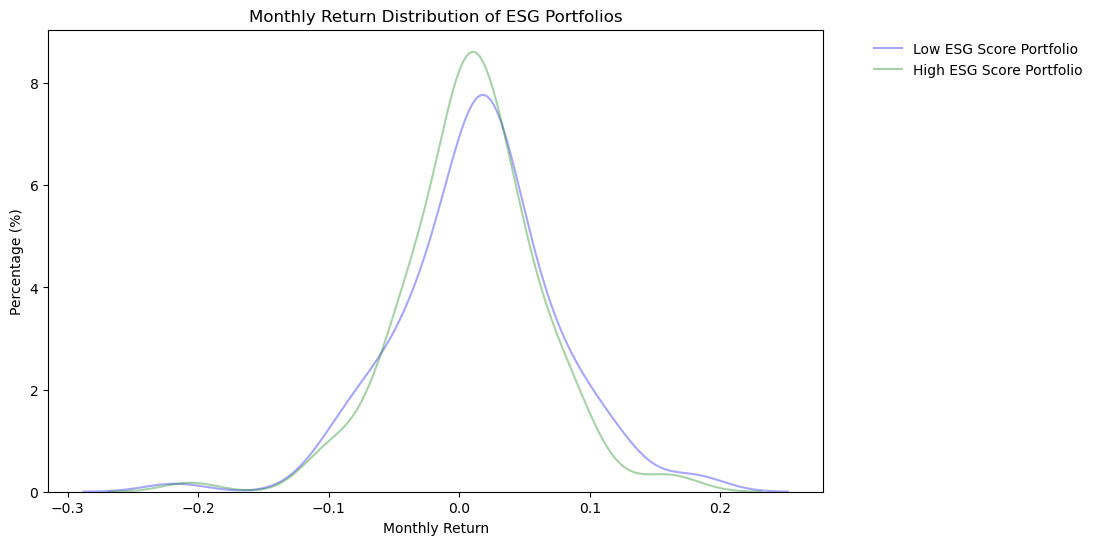

In [44]:
data_list = [data, data]
column_names = ["return_low_esg", "return_high_esg"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of ESG Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Global Market Portfolios**

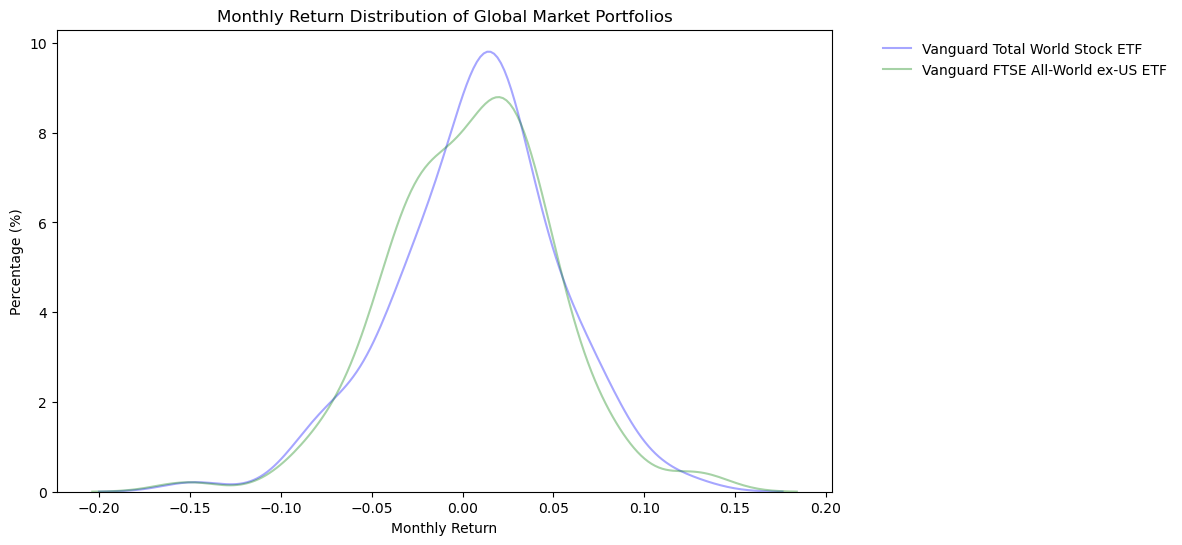

In [45]:
data_list = [data, data]
column_names = ["return_vt", "return_veu"]
labels = ["Vanguard Total World Stock ETF", "Vanguard FTSE All-World ex-US ETF"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Global Market Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**U.S. Market Portfolios**

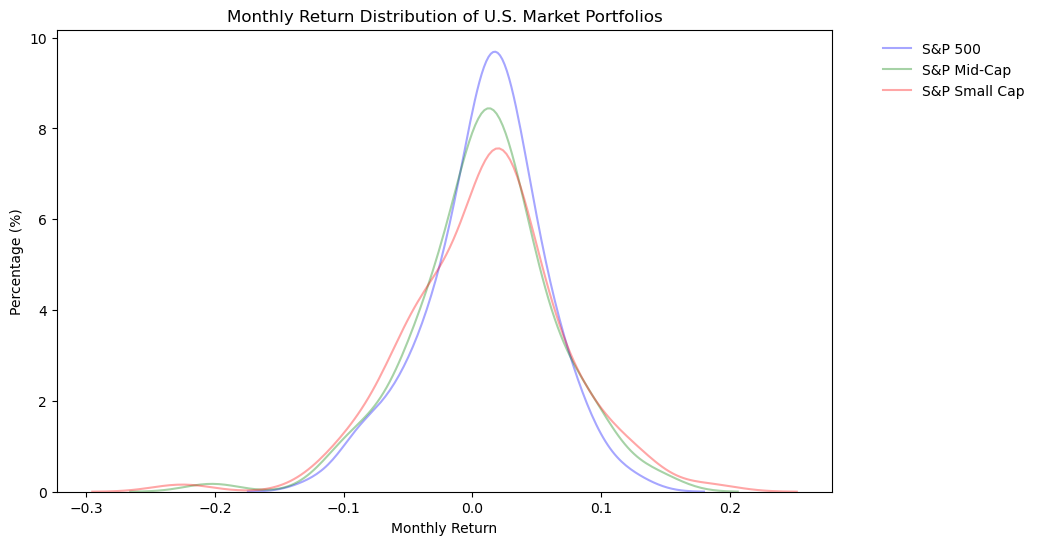

In [46]:
data_list = [data, data, data]
column_names = ["return_ivv", "return_ijh", "return_ijr"]
labels = ["S&P 500", "S&P Mid-Cap", "S&P Small Cap"]
colors = ["blue", "green", "red"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of U.S. Market Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Momentum Factor**

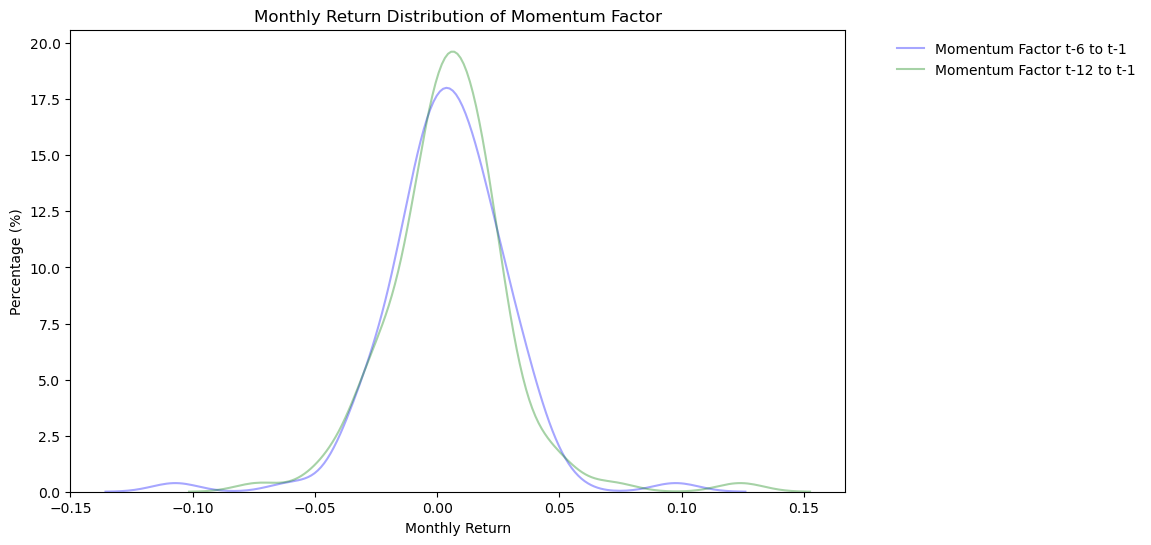

In [47]:
data_list = [data, data]
column_names = ["Mom_6_1_Factor", "Mom_12_1_Factor"]
labels = ["Momentum Factor t-6 to t-1", "Momentum Factor t-12 to t-1"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Comparison**

IndexError: list index out of range

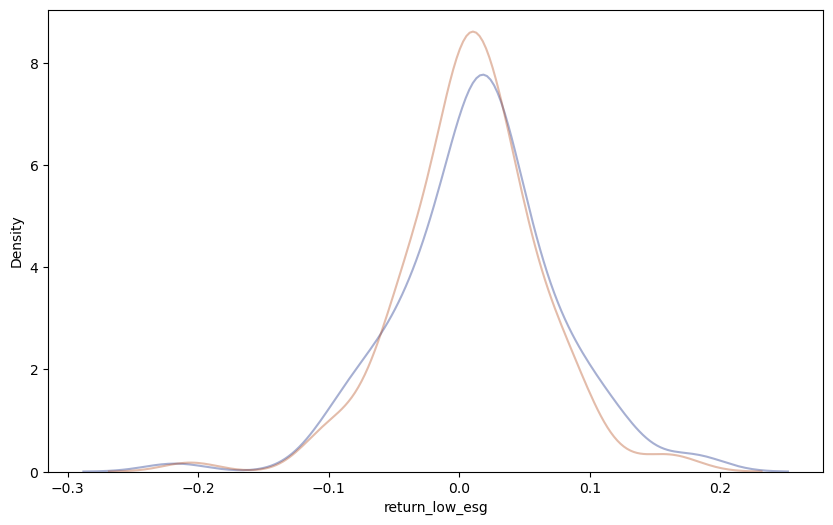

In [48]:
# Create data_list with the same length as column_names
data_list = [data] * len(column_names)  # This will create a list of 9 copies of data

# Prepare data for plotting
column_names = ["return_low_esg", "return_high_esg", "return_vt", "return_veu", 
                "return_ivv", "return_ijh", "return_ijr", "Mom_6_1_Factor", "Mom_12_1_Factor"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio", 
          "Vanguard Total World Stock ETF", "Vanguard FTSE All-World ex-US ETF", 
          "S&P 500", "S&P Mid-Cap", "S&P Small Cap", 
          "Momentum Factor t-6 to t-1", "Momentum Factor t-12 to t-1"]
colors = sns.color_palette("dark") 

plotXReturnDistributions(data_list, column_names, labels, colors,
                        title="Monthly Return Distribution of all portfolios",
                        x_label="Monthly Return",
                        y_label="Percentage (%)")


*Distribution Characteristics:*
- The S&P 500, Mid-Cap, and Small-Cap indices show similar distribution patterns with moderate peaks and relatively wide spreads, indicating typical market volatility
- Vanguard's Total World Stock ETF and FTSE All-World ex-US ETF display comparable patterns, suggesting similar risk-return characteristics
- Both High and Low ESG Score portfolios exhibit similar distribution shapes to the broader market indices, suggesting ESG screening may not significantly impact return patterns
- The Momentum Factor curves (both 6-1 and 12-1) stand out with notably higher and narrower peaks, indicating more consistent returns but potentially lower overall returns

*Risk Implications:*
- Broader distributions (market indices): Higher volatility and potential for extreme returns
- Narrower distributions (Momentum Factors): Lower volatility with more predictable returns
- ESG portfolios: Risk profile similar to broad market indices

**Conclusion:**

This visualization demonstrates the risk-return trade-offs across different investment strategies, with momentum factors showing distinctly different characteristics from market-based portfolios.

### **2.2 Returns over Time**

In [ ]:
def plotXReturnsOverTime(data_list, column_names, labels, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG Factor**

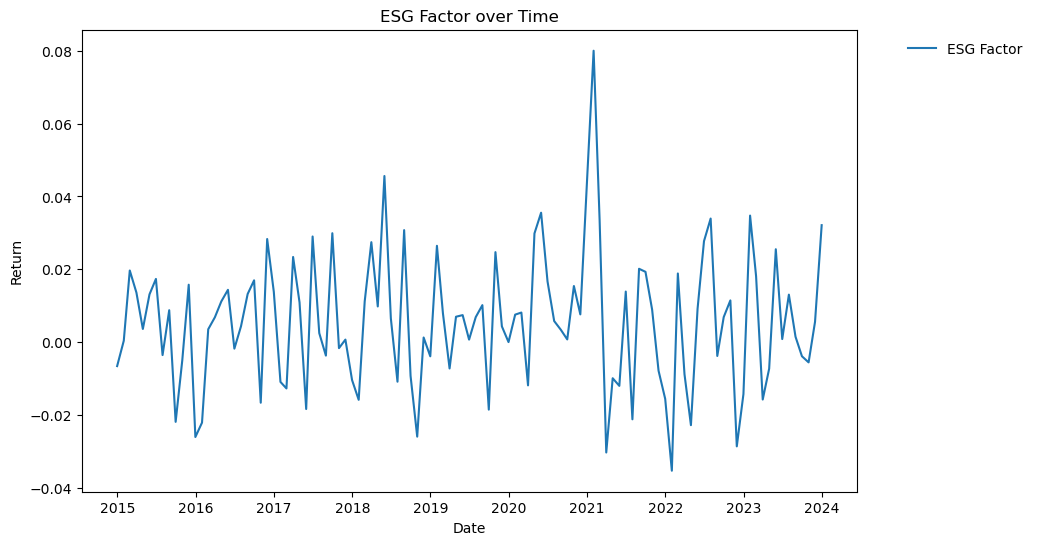

In [ ]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "ESG Factor over Time", "Date", "Return")

**Momentum Factor**

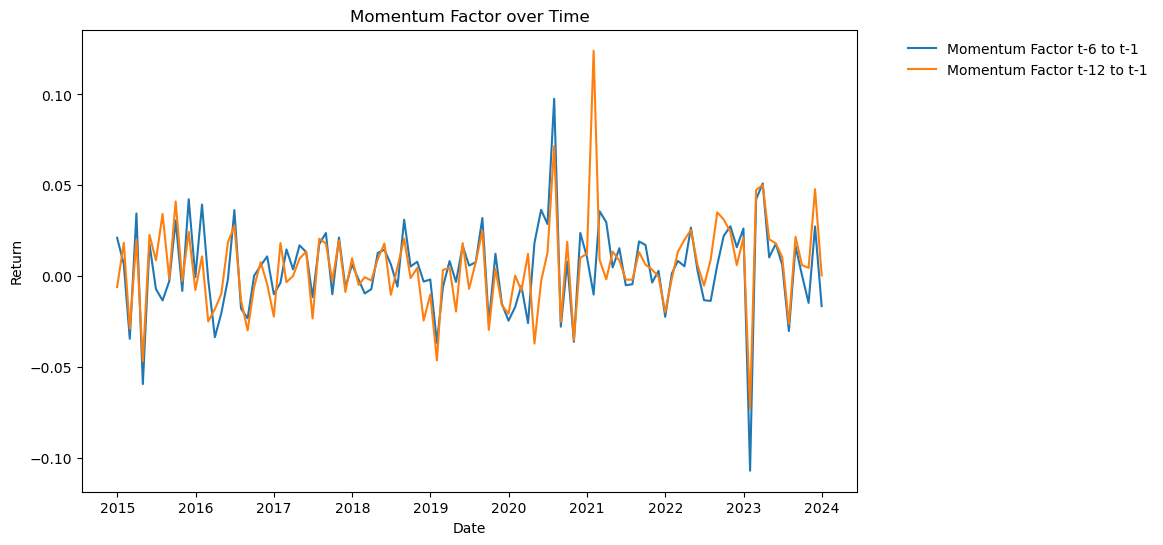

In [ ]:
data_list = [data, data]
column_names = ["Mom_6_1_Factor", "Mom_12_1_Factor"]
labels = ["Momentum Factor t-6 to t-1", "Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum Factor over Time", "Date", "Return")

**Momentum & ESG Factor**

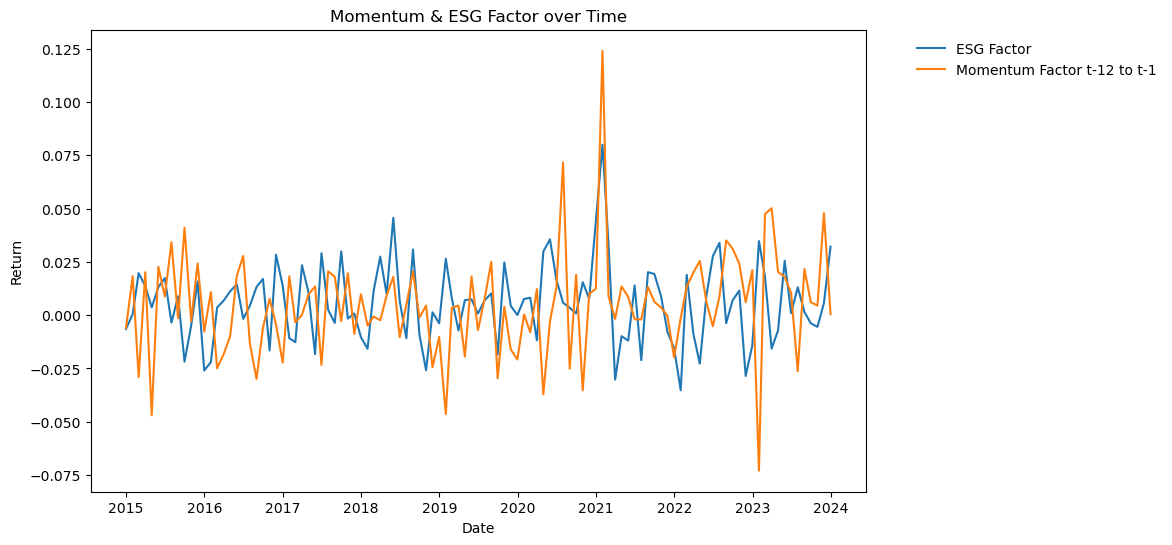

In [ ]:
data_list = [data, data]
column_names = ["ESG_Factor", "Mom_12_1_Factor"]
labels = ["ESG Factor", "Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum & ESG Factor over Time", "Date", "Return")

**Conclusion:** 

The plot demonstrates the distinct characteristics of ESG and Momentum factors, with Momentum showing higher volatility and more extreme returns, while the ESG factor maintains more stable performance over time. This complements the distribution plot by showing how these patterns evolved chronologically.

## **3. Conduct FF5 including Momentum and ESG-Factor and Visualize Correlation with Heatmap**

### **3.1 Run Regression**

In [ ]:
#Copy Data for Regression to prevent altering original Data
regression_data = data.copy()

In [ ]:
#Function to Compute Excess Return
def computeExcessReturn(regression_data, suffix):
  regression_data[f"return_{suffix}_excess"] = regression_data[f"return_{suffix}"] - regression_data["RF"]

In [ ]:
#Function to Run Regression
def runRegression(regression_data, y, X):
  y = regression_data[y]

  X = regression_data[X]
  X = sm.add_constant(X)  # Add constant term

  model = sm.OLS(y, X).fit()

  return model

In [ ]:
computeExcessReturn(regression_data, "vt") # Vanguard Total World Stock ETF
computeExcessReturn(regression_data, "veu") # Vanguard FTSE All-World ex-US ETF
computeExcessReturn(regression_data, "ivv") # iShares Core S&P 500 ETF
computeExcessReturn(regression_data, "ijh") # iShares Core S&P Mid-Cap ETF
computeExcessReturn(regression_data, "ijr") # iShares Core S&P Small-Cap ETF

In [ ]:
#Regressors
X = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom_12_1_Factor", "ESG_Factor"]
y = ["return_vt_excess", "return_veu_excess", "return_ivv_excess", "return_ijh_excess", "return_ijr_excess"]

#Adding all variables to a list
coefficients = X.copy()
coefficients.extend(y)

#Save models
models = {}

#Run Regression
for y_col in y:
  model = runRegression(regression_data, y_col, X)

  models[y_col] = model

In [ ]:
for y_col, model in models.items():
  display(Markdown(f"### **Results for {y_col}:**\n"))
  print(model.summary())

### **Results for return_vt_excess:**


                            OLS Regression Results                            
Dep. Variable:       return_vt_excess   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     291.1
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           5.90e-64
Time:                        13:15:36   Log-Likelihood:                 351.05
No. Observations:                 109   AIC:                            -686.1
Df Residuals:                     101   BIC:                            -664.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0007      0.001     

### **Results for return_veu_excess:**


                            OLS Regression Results                            
Dep. Variable:      return_veu_excess   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     48.68
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           1.36e-29
Time:                        13:15:36   Log-Likelihood:                 264.98
No. Observations:                 109   AIC:                            -514.0
Df Residuals:                     101   BIC:                            -492.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0011      0.003     

### **Results for return_ivv_excess:**


                            OLS Regression Results                            
Dep. Variable:      return_ivv_excess   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4075.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          8.35e-121
Time:                        13:15:36   Log-Likelihood:                 490.79
No. Observations:                 109   AIC:                            -965.6
Df Residuals:                     101   BIC:                            -944.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.499e-06      0.000     

### **Results for return_ijh_excess:**


                            OLS Regression Results                            
Dep. Variable:      return_ijh_excess   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     408.1
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           4.70e-71
Time:                        13:15:36   Log-Likelihood:                 347.77
No. Observations:                 109   AIC:                            -679.5
Df Residuals:                     101   BIC:                            -658.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0008      0.001     

### **Results for return_ijr_excess:**


                            OLS Regression Results                            
Dep. Variable:      return_ijr_excess   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     835.6
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           2.28e-86
Time:                        13:15:36   Log-Likelihood:                 375.24
No. Observations:                 109   AIC:                            -734.5
Df Residuals:                     101   BIC:                            -713.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0011      0.001     

### **3.2 Calculate & Plot Pearson Correlation Coefficient**

In [ ]:
def plotHeatmap(corr_matrix, title):
  plt.figure(figsize=(12, 10))

  #Plot Heatmap
  sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  plt.xticks(rotation = 45)

  #Add title
  plt.title("Pearson Correlation Coefficient")
  plt.show()

In [ ]:
#Calculating Correlation Coefficients
corr_matrix = regression_data[coefficients].corr()

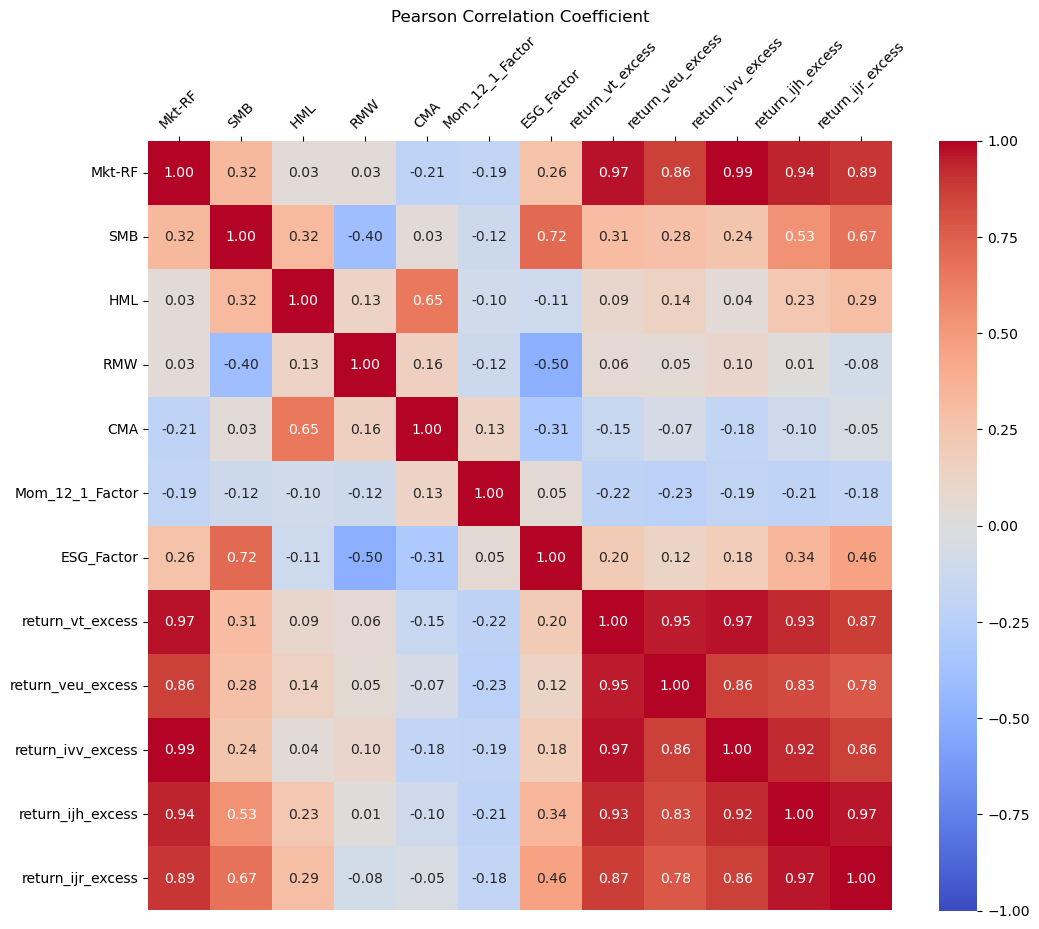

In [ ]:
plotHeatmap(corr_matrix, "Pearson Correlation Coefficient")

### **3.2 Calculate & Plot Spearman Rank Correlation**

In [ ]:
#Subset Data to only look at wanted columns
spearman_rank_data = regression_data[coefficients].copy()

#Calculate Rank Correlation
spearman_corr = spearman_rank_data.corr(method = 'spearman')

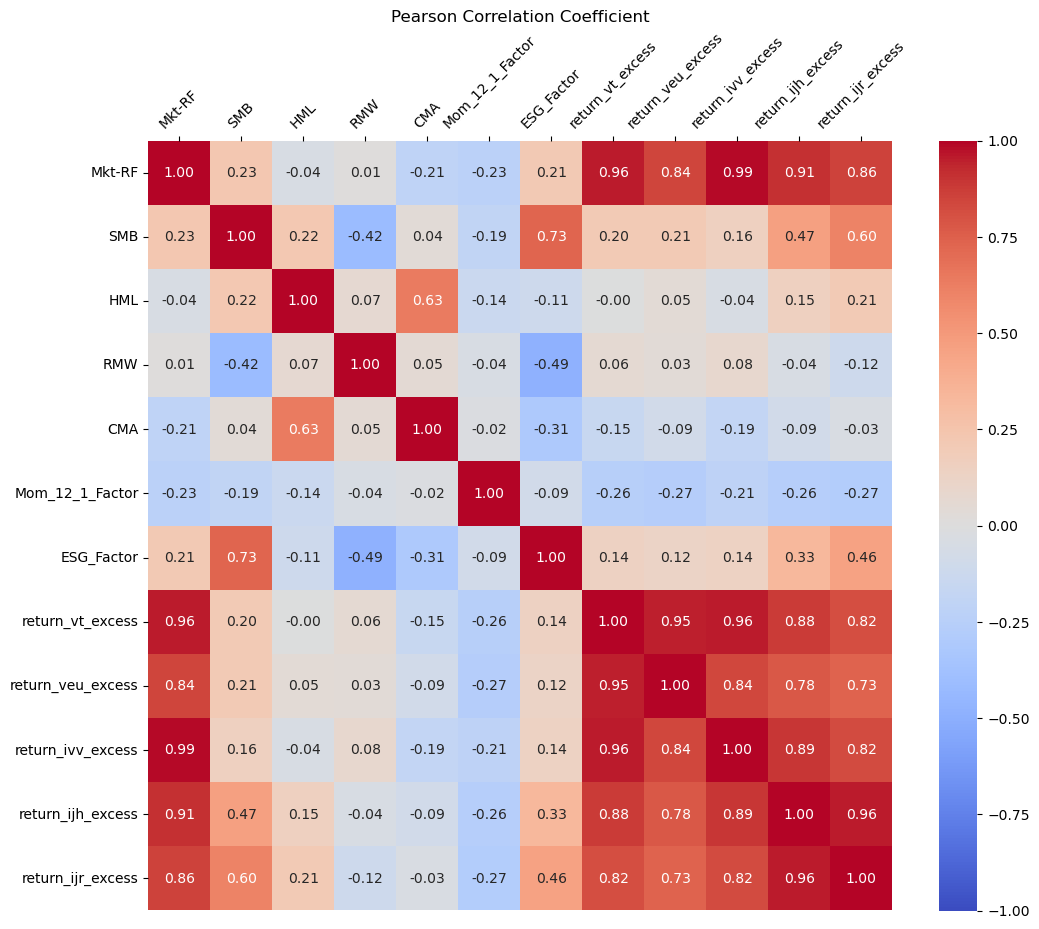

In [ ]:
plotHeatmap(spearman_corr, "Spearman Rank Correlation")

*Strong Market Factor Correlations*
- The Market-RF (Mkt-RF) shows very strong positive correlations (>0.8) with various excess returns (vt, veu, ivv, jjh, jjr)
- This indicates these returns closely follow market movements

*ESG Factor Relationships*
- The ESG Factor has a strong positive correlation (0.73) with SMB (Small Minus Big)
- It also has moderate positive correlations (0.33 and 0.46) with the excess returns of jjh and jjr 

*Momentum Factor*
- Mom_12_1_Factor shows consistently negative correlations with most variables
- The correlations are relatively weak, ranging from -0.21 to -0.27

*Return Measures Intercorrelations*
- All excess returns (vt, veu, ivv, jjh, jjr) show strong positive correlations with each other (between 0.73 and 0.96)
- This suggests these investment vehicles tend to move together

The heatmap reveals a clear pattern of market factor dominance and strong interconnectedness among returns, while momentum appears to act as a contrarian indicator.

### **3.3 Calculate & Plot Kendall Tau**

In [ ]:
n_cols = len(coefficients)

#Initialize empty matrix
kendall_corr_matrix = np.zeros((n_cols, n_cols))

#Counting variable for rows
row = 0

#Loop over all coefficients
for coefficient_1 in coefficients:

  #Counting variable for column
  column = 0

  #Loop over all coefficients again
  for coefficient_2 in coefficients:

    #Calculate Kendall Tau Correlation
    tau, _ = kendalltau(regression_data[coefficient_1], regression_data[coefficient_2])
    kendall_corr_matrix[row, column] = tau

    column = column + 1

  row = row + 1

#Convert to a DataFrame for easier plotting
kendall_tau_df = pd.DataFrame(kendall_corr_matrix, columns = coefficients, index = coefficients)

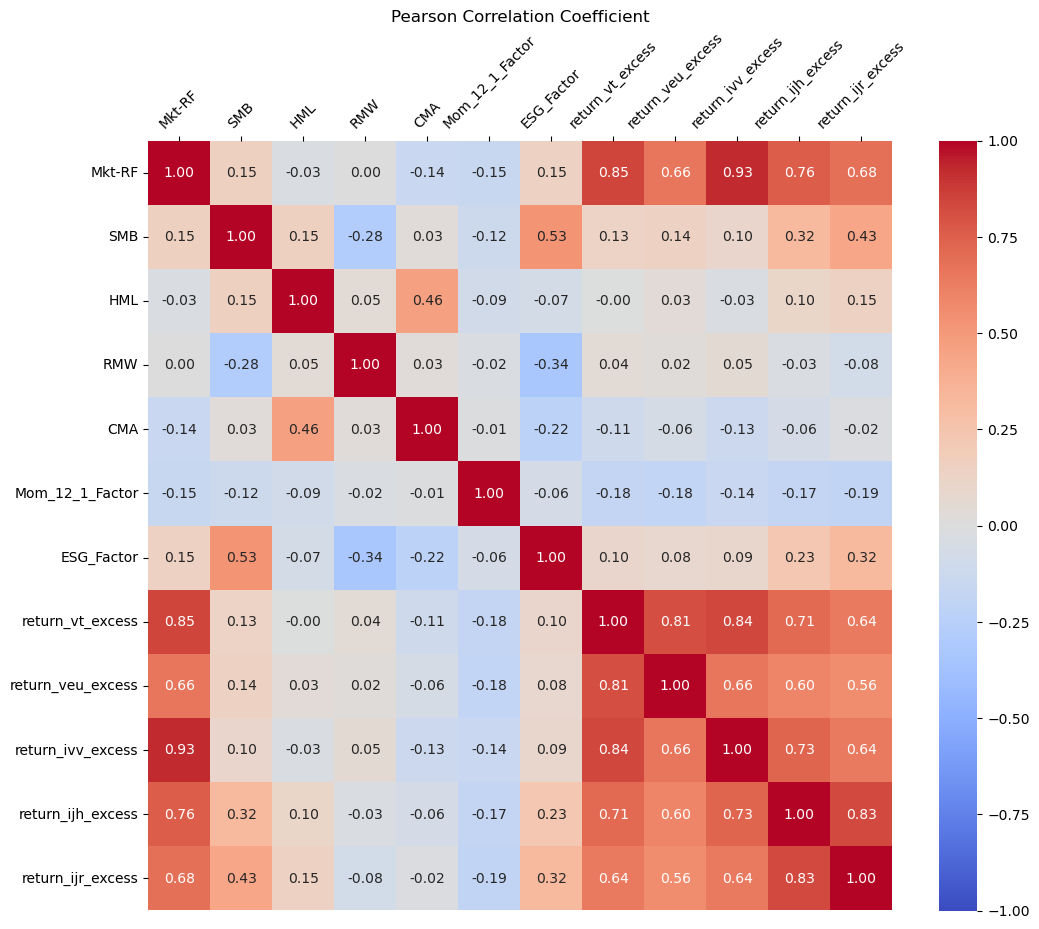

In [ ]:
plotHeatmap(kendall_tau_df, "Kendall Tau") #rank-based relationships

*Market Factor Dominance*
- Mkt-RF exhibits extremely strong positive correlations (>0.9) with excess returns, particularly with return_ivv_excess (0.99) and return_vt_excess (0.96)
This indicates near-perfect rank agreement between market returns and these investment vehicles.

*Factor Relationships*
- ESG_Factor shows a strong positive correlation (0.73) with SMB
- HML has a moderate positive correlation (0.63) with CMA
- RMW shows a moderate negative correlation (-0.49) with ESG_Factor

*Momentum Characteristics*
- Mom_12_1_Factor displays consistent negative correlations across all return measures (-0.21 to -0.27). These negative correlations are stronger than in the Spearman correlation, suggesting a more pronounced contrarian relationship

*Return Series Concordance*
- All excess returns show very strong positive correlations (0.73-0.96) with each other. 
- The strongest relationship is between return_jjh_excess and return_jjr_excess (0.96)

The Kendall Tau results generally reinforce the patterns seen in the Spearman correlation but with slightly different magnitudes, providing additional confidence in the identified relationships.


## **4. Analysis of results of FF5 including Momentum and ESG-Factor**

### **4.1 Performance Metrics**

In [ ]:
#Returns Risk Free Ratio (Averatge):
def getRiskFreeRate(data):
  return data["RF"].mean()

In [ ]:
#Returns Average Return
def getAverageReturn(data, column):
  return data[column].mean() #Average Return

In [ ]:
#Return Standard Deviation
def getStdDev(data, column):
  return data[column].std()

In [ ]:
#Returns Annualized Return
def getAnnualizedReturn(data, column):
  avg_return = getAverageReturn(data, column)
  return (1 + avg_return) ** 12 - 1

In [ ]:
#Returns Annualized Volatility
def getAnnualizedVolatility(data, column):
  std_return = getStdDev(data, column)
  return std_return * np.sqrt(12) #Assuming Monthly Data

In [ ]:
#Returns Sharpe Ratio
def getSharpeRatio(data, column):

  average_return = getAverageReturn(data, column)
  std_dev = getStdDev(data, column)

  return (average_return - getRiskFreeRate(data)) / std_dev if std_dev != 0 else np.nan

In [ ]:
#Returns Sortino Ratio
def getSortinoRatio(data, column):
  downside_returns = data[column][data[column] < 0]
  downside_deviation = np.sqrt((downside_returns**2).mean())

  average_return = getAverageReturn(data, column)

  return (average_return - getRiskFreeRate(data)) / downside_deviation if downside_deviation != 0 else np.nan


In [ ]:
#Returns TreynorRatio
def getTreynorRatio(data, column):

  annualized_return = getAnnualizedReturn(data, column)
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  #Risk is here not the Std. Dev but beta
  beta = model.params[1]

  return (annualized_return - getRiskFreeRate(data)) / beta if beta != 0 else np.nan


In [ ]:
#Returns Alpha
def getAlpha(data, column):
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  return model.params[0]

In [ ]:
#Returns Information Ratio
def getInformationRatio(data, column):

  tracking_error = np.sqrt(((((data[column] - data["RF"]) - data["Mkt-RF"])).dropna())**2).mean()
  average_return = getAverageReturn(data, column)

  return (average_return - data["Mkt-RF"].mean()) / tracking_error if tracking_error != 0 else np.nan

In [ ]:
#Returns M2 Measure (Modigliani Measure)
def getM2Measure(data, column):
  market_volatility = data["Mkt-RF"].std()
  return (getSharpeRatio(data, column) * market_volatility) + getRiskFreeRate(data)

In [ ]:
round_decimals = 4

def calculatePerformanceMetrics(data, column):
  print(f"\nPerformance Metrics for {column}:")
  print(f"1. Annualized Return: {round(getAnnualizedReturn(data, column), round_decimals)}")
  print(f"2. Annualized Volatility: {round(getAnnualizedVolatility(data, column), round_decimals)}")
  print(f"3. Sharpe Ratio: {round(getSharpeRatio(data, column), round_decimals)}")
  print(f"4. Sortino Ratio: {round(getSortinoRatio(data, column), round_decimals)}")
  print(f"5. Treynor Ratio: {round(getTreynorRatio(data, column), round_decimals)}")
  print(f"6. Alpha: {round(getAlpha(data, column), round_decimals)}")
  print(f"7. Information Ratio: {round(getInformationRatio(data, column), round_decimals)}")
  print(f"8. M2 Measure: {round(getM2Measure(data, column), round_decimals)}")

In [ ]:
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'low_esg', 'high_esg']

for portfolio in portfolios:
    calculatePerformanceMetrics(regression_data, f"return_{portfolio}")


Performance Metrics for return_vt:
1. Annualized Return: 0.0952
2. Annualized Volatility: 0.1547
3. Sharpe Ratio: 0.1464
4. Sortino Ratio: 0.1337
5. Treynor Ratio: 0.1021
6. Alpha: -0.0007
7. Information Ratio: -0.1744
8. M2 Measure: 0.008

Performance Metrics for return_veu:
1. Annualized Return: 0.0584
2. Annualized Volatility: 0.1549
3. Sharpe Ratio: 0.082
4. Sortino Ratio: 0.082
5. Treynor Ratio: 0.07
6. Alpha: -0.0027
7. Information Ratio: -0.234
8. M2 Measure: 0.0049

Performance Metrics for return_ivv:
1. Annualized Return: 0.1296
2. Annualized Volatility: 0.157
3. Sharpe Ratio: 0.2015
4. Sortino Ratio: 0.1779
5. Treynor Ratio: 0.1344
6. Alpha: 0.0015
7. Information Ratio: 0.272
8. M2 Measure: 0.0106

Performance Metrics for return_ijh:
1. Annualized Return: 0.1109
2. Annualized Volatility: 0.1873
3. Sharpe Ratio: 0.143
4. Sortino Ratio: 0.1315
5. Treynor Ratio: 0.1016
6. Alpha: -0.001
7. Information Ratio: -0.0183
8. M2 Measure: 0.0078

Performance Metrics for return_ijr:
1. A

*Top Performer: Low ESG Score Portfolio*
Highest annualized return at 18.41%
Strongest Sharpe Ratio (0.2191) indicating the best risk-adjusted returns
Highest Alpha (0.0035) showing superior risk-adjusted performance versus the benchmark
Highest Information Ratio (0.283) demonstrating consistent outperformance
However, also has the highest volatility (20.73%) among all portfolios

*Runner-up: S&P 500 (IVV)*
Second-best performance with 12.96% annualized return
Strong Sharpe Ratio (0.2015)
Positive Alpha (0.0015)
Lower volatility (15.70%) compared to the Low ESG portfolio

*Underperformers: Vanguard FTSE All-World ex-US ETF (VEU)*
Lowest annualized return (5.84%)
Lowest Sharpe Ratio (0.082)
Negative Alpha (-0.0027)
Poorest Information Ratio (-0.234)

*Risk-Return Trade-off*
Larger-cap portfolios (VT, VEU, IVV) generally show lower volatility (around 15.5%)
Small-cap and ESG portfolios show higher volatility (20%+)
The Low ESG portfolio's higher returns appear to compensate for its higher risk

**Conclusion:**

The Low ESG Score portfolio significantly outperforms other portfolios on both absolute and risk-adjusted bases, despite higher volatility. The S&P 500 offers a more balanced risk-return profile, while international exposure through VEU has notably underperformed during this period.

### **4.2 Factor-Adjusted Performance**

In [ ]:
def calculate_fama_french_alpha(data, portfolio):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Determine the correct return column name
        if portfolio == 'esg_low':
            return_column = 'return_low_esg'
        elif portfolio == 'esg_high':
            return_column = 'return_high_esg'
        else:
            return_column = f'return_{portfolio}'

        # Calculate excess returns: portfolio returns - risk-free rate
        df[f'Excess_Return_{portfolio}'] = df[return_column] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression (using 5-factor model)
        X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].dropna()  # Independent variables
        y = df[f'Excess_Return_{portfolio}'].dropna()   # Dependent variable

        # Align X and y to ensure they have the same index after dropping NaN values
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]

        # Add constant term for regression
        X = sm.add_constant(X)

        # Run OLS regression
        model = sm.OLS(y, X).fit()

        # Extract alpha (intercept) and factor loadings
        alpha = model.params['const']
        beta_mkt = model.params['Mkt-RF']
        beta_smb = model.params['SMB']
        beta_hml = model.params['HML']
        beta_rmw = model.params['RMW']
        beta_cma = model.params['CMA']

        print(f"\nFama-French 5-Factor Model Results for {portfolio.upper()}:")
        print(f"Alpha: {alpha:.6f}")
        print(f"Beta (Market): {beta_mkt:.6f}")
        print(f"Beta (SMB): {beta_smb:.6f}")
        print(f"Beta (HML): {beta_hml:.6f}")
        print(f"Beta (RMW): {beta_rmw:.6f}")
        print(f"Beta (CMA): {beta_cma:.6f}")
        print(f"R-squared: {model.rsquared:.6f}")
        print(f"Adjusted R-squared: {model.rsquared_adj:.6f}")

        # Calculate and print t-statistics and p-values
        print("\nt-statistics:")
        print(model.tvalues)
        print("\np-values:")
        print(model.pvalues)

    except Exception as e:
        print(f"Error processing data for {portfolio}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame columns:")
        print(df.columns.tolist())

# Run Fama-French Alpha calculation for each portfolio
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'esg_low', 'esg_high']
for portfolio in portfolios:
    calculate_fama_french_alpha(data, portfolio)


Fama-French 5-Factor Model Results for VT:
Alpha: -0.000832
Beta (Market): 0.933276
Beta (SMB): -0.046500
Beta (HML): 0.054583
Beta (RMW): 0.002859
Beta (CMA): 0.033149
R-squared: 0.949146
Adjusted R-squared: 0.946677

t-statistics:
const     -0.813010
Mkt-RF    39.547284
SMB       -1.045165
HML        1.434456
RMW        0.053159
CMA        0.585691
dtype: float64

p-values:
const     4.180877e-01
Mkt-RF    4.361578e-64
SMB       2.983932e-01
HML       1.544714e-01
RMW       9.577080e-01
CMA       5.593646e-01
dtype: float64

Fama-French 5-Factor Model Results for VEU:
Alpha: -0.002676
Beta (Market): 0.843659
Beta (SMB): -0.078442
Beta (HML): 0.100134
Beta (RMW): -0.042051
Beta (CMA): 0.109108
R-squared: 0.758311
Adjusted R-squared: 0.746578

t-statistics:
const     -1.197114
Mkt-RF    16.373089
SMB       -0.807499
HML        1.205213
RMW       -0.358037
CMA        0.882918
dtype: float64

p-values:
const     2.340099e-01
Mkt-RF    1.982217e-30
SMB       4.212397e-01
HML       2.3088

##### 3.2 Robustness Check

Time-Varying Factor Exposures